# Program Description: Machine Learning Modeling (MLP Regression - Module 10)

## Overview:
This module is responsible for building a multi-layer perceptron (MLP) regression model, training it on the provided dataset, and saving the best model after training. The input dataset (feature and label files) is loaded from the output of **Module 9** (where the dataset has been normalized).

## Key Steps:

1. **Dataset Loading**:
   - The module reads the **normalized dataset** (train and validation sets) generated in **Module 9**.
   - The dataset includes both **features** and **labels** required for training the model.

2. **Model Construction**:
   - An MLP regression model is built using the loaded dataset.
   - The model is configured and optimized for regression tasks.

3. **Training and Evaluation**:
   - The model is trained using the provided **training dataset**.
   - The performance of the model is evaluated using the **validation dataset**.
   - Hyperparameter tuning may be applied to improve the model's accuracy.

4. **Model Saving and Prediction**:
   - After training, the **best model** (based on validation performance) is saved.
   - The trained model is used to make predictions on the test set or additional unseen data.

## Output:
- The best trained model is saved in the `datasets-ml` folder under the current path. The saved model is named as follows:
  - `MLPmodel--{current_time}`, where `{current_time}` is the timestamp of the training session.

## Note:
- This module is parallel to other network models, meaning it can be used with other models or in conjunction with other training pipelines.
- The input data is provided as the output of **Module 9** (dataset normalization).


contacts：zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import logging
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import regularizers
import keras.callbacks
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

2025-01-21 10:02:31.104900: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['tensorflow', 'numpy', 'joblib', 'matplotlib','keras']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

tensorflow: 2.9.1
numpy: 1.23.5
joblib: 1.4.0
matplotlib: 3.7.5
keras: 2.9.0
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings

## Input File Path:
- `dir_data`: Specifies the directory where the processed dataset (after preprocessing in Module 9) is located.
- Example: `'0926-datasets/datasets(JmolNN)-pre-xmu-cn'`
- The dataset includes **training**, **validation**, and **test** (features and labels), loaded from this directory.

## Output File Path:
- `dir_output`: The directory where the trained MLP model will be saved.
- The trained model is saved under the `ml-cn-xmu-(JmolNN)` folder, with a timestamp added to the model file name.
- Example: `'0926-datasets-ml/ml-cn-xmu-(JmolNN)'`
- The final model is saved with a filename that includes a timestamp for version tracking, e.g., `MLPmodel-20230101_1500`.

## Logging:
- `log_file_path`: The path where the training log file (`training_log.txt`) will be stored.
- This log file contains details about the dataset sizes, model training progress, and other relevant information.

## Model Hyperparameters (Structural Parameters):
The following parameters can be customized within the Multi-Layer Percet in the code yet:

- **Hidden Layers**: The number of hidden layers and their neuron sizes in the MLP.
  - Example: `[64, 32]` (two hidden layers with 64 and 32 neurons).
  
- **Activation Function**: The activation function used for the layers in the network.
  - Options: `'relu'`, `'tanh'`, `'sigmoid'`, etc.
  - Default: `'relu'`.
  
- **Learning Rate**: The learning rate for the optimization process.
  - Example: `0.001`.
  
- **Epochs**: Number of epochs to train the model.
  - Example: `50`.

- **Optimizer**: The optimization algorithm to be used.
  - Options: `'adam'`, `'sgd'`, etc.
  - Default: `'adam'`.
  
- **Loss Function**: The loss function used to optimize the model.
  - Example: `'mean_squared_error'` (commonly used for regression).
  
- **Batch Size**: The batch size for training the model.
  - Example: `32`.

In [3]:
# Set input file path
dir_data = '0926-datasets/datasets(JmolNN)-pre-xmu-cn'
# Set output file save path
output_path = '0926-datasets-ml/ml-cn-xmu-(JmolNN)'
current_time = datetime.now().strftime("%Y%m%d_%H%M")
# Output save file name and add timestamp
dir_output=os.path.join(output_path,f'MLPmodel-{current_time}')
# Check if the input path exists
if os.path.exists(dir_data):
    print(f"File '{dir_data}' exists.")
else:
    raise FileNotFoundError(f"File '{dir_data}' does not exist.")
os.makedirs(dir_output, exist_ok=True)
os.makedirs(dir_output, exist_ok=True)
# Load training, validation, and test datasets
file_train_feature = os.path.join(dir_data, 'xmu_train_JmolNN.txt')
file_train_label = os.path.join(dir_data, 'label_cn_train_JmolNN.txt')
file_valid_feature = os.path.join(dir_data, 'xmu_valid_JmolNN.txt')
file_valid_label = os.path.join(dir_data, 'label_cn_valid_JmolNN.txt')
file_test_feature = os.path.join(dir_data, 'xmu_test_JmolNN.txt')
file_test_label = os.path.join(dir_data, 'label_cn_test_JmolNN.txt')
log_file_path = os.path.join(dir_output, 'training_log.txt')
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_file_path), logging.StreamHandler()])
# Read data
X_train = np.loadtxt(file_train_feature)
y_train = np.loadtxt(file_train_label, dtype=float)
X_valid = np.loadtxt(file_valid_feature)
y_valid = np.loadtxt(file_valid_label, dtype=float)
X_test = np.loadtxt(file_test_feature)
y_test = np.loadtxt(file_test_label, dtype=float)
# Prepare messages for dataset sizes
train_size_message = f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}"
valid_size_message = f"Validation set size: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}"
test_size_message = f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}"
print(train_size_message)
print(valid_size_message)
print(test_size_message)
# Log dataset sizes
logging.info(train_size_message)
logging.info(valid_size_message)
logging.info(test_size_message)

File '0926-datasets/datasets(JmolNN)-pre-xmu-cn' exists.


Training set size: X_train: (3465, 1000), y_train: (3465,)
Validation set size: X_valid: (990, 1000), y_valid: (990,)
Test set size: X_test: (495, 1000), y_test: (495,)


Training set size: X_train: (3465, 1000), y_train: (3465,)
Validation set size: X_valid: (990, 1000), y_valid: (990,)
Test set size: X_test: (495, 1000), y_test: (495,)


## Build a MLP regression model and save the best model results

In [4]:
# Standardize data
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)
#scaler_path = os.path.join(dir_output, 'scaler.pkl')
#joblib.dump(scaler, scaler_path)
#print(f"Scaler saved to: {scaler_path}")
# Build the mlp model
#model = Sequential()
#model.add(Dense(400, input_dim=X_train.shape[1], activation='relu'))  # Input layer and first hidden layer
#model.add(Dense(200, activation='relu'))
#model.add(Dense(100, activation='relu'))  # Second hidden layer
#model.add(Dense(1))  # Output layer with linear activation function (default)
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
# Set model save path
model_file = os.path.join(dir_output, 'best_model.h5')
# Set callbacks to save the model with the best performance on the validation set and to log training process
checkpoint = ModelCheckpoint(model_file, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
# Custom callback class to log training process
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_message = (f"Epoch {epoch + 1}, "
                       f"Loss: {logs['loss']:.4f}, "
                       f"MSE: {logs['mean_squared_error']:.4f}, "
                       f"Val_Loss: {logs['val_loss']:.4f}, "
                       f"Val_MSE: {logs['val_mean_squared_error']:.4f}")
        logging.info(log_message)
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=32, callbacks=[checkpoint, CustomCallback()])


Epoch 1/100


2025-01-21 10:02:34.244709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


109/109 [==============================] - ETA: 0s - loss: 4.7116 - mean_squared_error: 4.5828
Epoch 1: val_mean_squared_error improved from inf to 1.72770, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 1, Loss: 4.7116, MSE: 4.5828, Val_Loss: 1.8546, Val_MSE: 1.7277


109/109 [==============================] - 1s 8ms/step - loss: 4.7116 - mean_squared_error: 4.5828 - val_loss: 1.8546 - val_mean_squared_error: 1.7277
Epoch 2/100
106/109 [============================>.] - ETA: 0s - loss: 2.1471 - mean_squared_error: 2.0205
Epoch 2: val_mean_squared_error did not improve from 1.72770


Epoch 2, Loss: 2.1528, MSE: 2.0262, Val_Loss: 2.5197, Val_MSE: 2.3933


109/109 [==============================] - 1s 6ms/step - loss: 2.1528 - mean_squared_error: 2.0262 - val_loss: 2.5197 - val_mean_squared_error: 2.3933
Epoch 3/100
107/109 [============================>.] - ETA: 0s - loss: 1.5814 - mean_squared_error: 1.4552
Epoch 3: val_mean_squared_error improved from 1.72770 to 1.45260, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 3, Loss: 1.5780, MSE: 1.4518, Val_Loss: 1.5785, Val_MSE: 1.4526


109/109 [==============================] - 1s 6ms/step - loss: 1.5780 - mean_squared_error: 1.4518 - val_loss: 1.5785 - val_mean_squared_error: 1.4526
Epoch 4/100
108/109 [============================>.] - ETA: 0s - loss: 1.3157 - mean_squared_error: 1.1900
Epoch 4: val_mean_squared_error improved from 1.45260 to 1.10303, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 4, Loss: 1.3170, MSE: 1.1914, Val_Loss: 1.2284, Val_MSE: 1.1030


109/109 [==============================] - 1s 6ms/step - loss: 1.3170 - mean_squared_error: 1.1914 - val_loss: 1.2284 - val_mean_squared_error: 1.1030
Epoch 5/100
106/109 [============================>.] - ETA: 0s - loss: 1.1590 - mean_squared_error: 1.0339
Epoch 5: val_mean_squared_error improved from 1.10303 to 1.07322, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 5, Loss: 1.1657, MSE: 1.0406, Val_Loss: 1.1980, Val_MSE: 1.0732


109/109 [==============================] - 1s 6ms/step - loss: 1.1657 - mean_squared_error: 1.0406 - val_loss: 1.1980 - val_mean_squared_error: 1.0732
Epoch 6/100
100/109 [==========================>...] - ETA: 0s - loss: 1.0482 - mean_squared_error: 0.9237
Epoch 6: val_mean_squared_error improved from 1.07322 to 0.99999, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 6, Loss: 1.0348, MSE: 0.9103, Val_Loss: 1.1242, Val_MSE: 1.0000


109/109 [==============================] - 1s 6ms/step - loss: 1.0348 - mean_squared_error: 0.9103 - val_loss: 1.1242 - val_mean_squared_error: 1.0000
Epoch 7/100
105/109 [===========================>..] - ETA: 0s - loss: 0.9759 - mean_squared_error: 0.8519
Epoch 7: val_mean_squared_error improved from 0.99999 to 0.73098, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 7, Loss: 0.9807, MSE: 0.8567, Val_Loss: 0.8546, Val_MSE: 0.7310


109/109 [==============================] - 1s 6ms/step - loss: 0.9807 - mean_squared_error: 0.8567 - val_loss: 0.8546 - val_mean_squared_error: 0.7310
Epoch 8/100
108/109 [============================>.] - ETA: 0s - loss: 0.8965 - mean_squared_error: 0.7731
Epoch 8: val_mean_squared_error did not improve from 0.73098


Epoch 8, Loss: 0.8956, MSE: 0.7721, Val_Loss: 1.2229, Val_MSE: 1.0997


109/109 [==============================] - 1s 6ms/step - loss: 0.8956 - mean_squared_error: 0.7721 - val_loss: 1.2229 - val_mean_squared_error: 1.0997
Epoch 9/100
108/109 [============================>.] - ETA: 0s - loss: 0.8538 - mean_squared_error: 0.7309
Epoch 9: val_mean_squared_error improved from 0.73098 to 0.67180, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 9, Loss: 0.8536, MSE: 0.7308, Val_Loss: 0.7943, Val_MSE: 0.6718


109/109 [==============================] - 1s 6ms/step - loss: 0.8536 - mean_squared_error: 0.7308 - val_loss: 0.7943 - val_mean_squared_error: 0.6718
Epoch 10/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.8136 - mean_squared_error: 0.6913
Epoch 10: val_mean_squared_error did not improve from 0.67180


Epoch 10, Loss: 0.8330, MSE: 0.7108, Val_Loss: 1.1692, Val_MSE: 1.0473


109/109 [==============================] - 1s 6ms/step - loss: 0.8330 - mean_squared_error: 0.7108 - val_loss: 1.1692 - val_mean_squared_error: 1.0473
Epoch 11/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.8032 - mean_squared_error: 0.6814
Epoch 11: val_mean_squared_error did not improve from 0.67180


Epoch 11, Loss: 0.8146, MSE: 0.6928, Val_Loss: 1.2481, Val_MSE: 1.1267


109/109 [==============================] - 1s 6ms/step - loss: 0.8146 - mean_squared_error: 0.6928 - val_loss: 1.2481 - val_mean_squared_error: 1.1267
Epoch 12/100
105/109 [===========================>..] - ETA: 0s - loss: 0.7450 - mean_squared_error: 0.6239
Epoch 12: val_mean_squared_error improved from 0.67180 to 0.62516, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 12, Loss: 0.7463, MSE: 0.6252, Val_Loss: 0.7458, Val_MSE: 0.6252


109/109 [==============================] - 1s 6ms/step - loss: 0.7463 - mean_squared_error: 0.6252 - val_loss: 0.7458 - val_mean_squared_error: 0.6252
Epoch 13/100
107/109 [============================>.] - ETA: 0s - loss: 0.8048 - mean_squared_error: 0.6844
Epoch 13: val_mean_squared_error improved from 0.62516 to 0.52849, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 13, Loss: 0.8068, MSE: 0.6864, Val_Loss: 0.6487, Val_MSE: 0.5285


109/109 [==============================] - 1s 7ms/step - loss: 0.8068 - mean_squared_error: 0.6864 - val_loss: 0.6487 - val_mean_squared_error: 0.5285
Epoch 14/100
100/109 [==========================>...] - ETA: 0s - loss: 0.6730 - mean_squared_error: 0.5532
Epoch 14: val_mean_squared_error did not improve from 0.52849


Epoch 14, Loss: 0.6701, MSE: 0.5504, Val_Loss: 0.6523, Val_MSE: 0.5330


109/109 [==============================] - 1s 6ms/step - loss: 0.6701 - mean_squared_error: 0.5504 - val_loss: 0.6523 - val_mean_squared_error: 0.5330
Epoch 15/100
100/109 [==========================>...] - ETA: 0s - loss: 0.7227 - mean_squared_error: 0.6037
Epoch 15: val_mean_squared_error improved from 0.52849 to 0.50571, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 15, Loss: 0.7143, MSE: 0.5954, Val_Loss: 0.6242, Val_MSE: 0.5057


109/109 [==============================] - 1s 6ms/step - loss: 0.7143 - mean_squared_error: 0.5954 - val_loss: 0.6242 - val_mean_squared_error: 0.5057
Epoch 16/100
107/109 [============================>.] - ETA: 0s - loss: 0.7036 - mean_squared_error: 0.5854
Epoch 16: val_mean_squared_error improved from 0.50571 to 0.45231, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 16, Loss: 0.7044, MSE: 0.5862, Val_Loss: 0.5701, Val_MSE: 0.4523


109/109 [==============================] - 1s 7ms/step - loss: 0.7044 - mean_squared_error: 0.5862 - val_loss: 0.5701 - val_mean_squared_error: 0.4523
Epoch 17/100
100/109 [==========================>...] - ETA: 0s - loss: 0.6457 - mean_squared_error: 0.5284
Epoch 17: val_mean_squared_error did not improve from 0.45231


Epoch 17, Loss: 0.6511, MSE: 0.5338, Val_Loss: 0.5974, Val_MSE: 0.4805


109/109 [==============================] - 1s 6ms/step - loss: 0.6511 - mean_squared_error: 0.5338 - val_loss: 0.5974 - val_mean_squared_error: 0.4805
Epoch 18/100
108/109 [============================>.] - ETA: 0s - loss: 0.6159 - mean_squared_error: 0.4994
Epoch 18: val_mean_squared_error did not improve from 0.45231


Epoch 18, Loss: 0.6157, MSE: 0.4992, Val_Loss: 0.6240, Val_MSE: 0.5080


109/109 [==============================] - 1s 6ms/step - loss: 0.6157 - mean_squared_error: 0.4992 - val_loss: 0.6240 - val_mean_squared_error: 0.5080
Epoch 19/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.6534 - mean_squared_error: 0.5378
Epoch 19: val_mean_squared_error did not improve from 0.45231


Epoch 19, Loss: 0.6510, MSE: 0.5354, Val_Loss: 0.8124, Val_MSE: 0.6972


109/109 [==============================] - 1s 6ms/step - loss: 0.6510 - mean_squared_error: 0.5354 - val_loss: 0.8124 - val_mean_squared_error: 0.6972
Epoch 20/100
100/109 [==========================>...] - ETA: 0s - loss: 0.6211 - mean_squared_error: 0.5064
Epoch 20: val_mean_squared_error did not improve from 0.45231


Epoch 20, Loss: 0.6221, MSE: 0.5073, Val_Loss: 0.5857, Val_MSE: 0.4714


109/109 [==============================] - 1s 6ms/step - loss: 0.6221 - mean_squared_error: 0.5073 - val_loss: 0.5857 - val_mean_squared_error: 0.4714
Epoch 21/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.7363 - mean_squared_error: 0.6222
Epoch 21: val_mean_squared_error did not improve from 0.45231


Epoch 21, Loss: 0.7281, MSE: 0.6141, Val_Loss: 0.9784, Val_MSE: 0.8647


109/109 [==============================] - 1s 6ms/step - loss: 0.7281 - mean_squared_error: 0.6141 - val_loss: 0.9784 - val_mean_squared_error: 0.8647
Epoch 22/100
106/109 [============================>.] - ETA: 0s - loss: 0.6677 - mean_squared_error: 0.5543
Epoch 22: val_mean_squared_error did not improve from 0.45231


Epoch 22, Loss: 0.6655, MSE: 0.5521, Val_Loss: 0.6319, Val_MSE: 0.5189


109/109 [==============================] - 1s 6ms/step - loss: 0.6655 - mean_squared_error: 0.5521 - val_loss: 0.6319 - val_mean_squared_error: 0.5189
Epoch 23/100
109/109 [==============================] - ETA: 0s - loss: 0.5763 - mean_squared_error: 0.4637
Epoch 23: val_mean_squared_error did not improve from 0.45231


Epoch 23, Loss: 0.5763, MSE: 0.4637, Val_Loss: 0.6745, Val_MSE: 0.5625


109/109 [==============================] - 1s 6ms/step - loss: 0.5763 - mean_squared_error: 0.4637 - val_loss: 0.6745 - val_mean_squared_error: 0.5625
Epoch 24/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.5761 - mean_squared_error: 0.4643
Epoch 24: val_mean_squared_error did not improve from 0.45231


Epoch 24, Loss: 0.5743, MSE: 0.4626, Val_Loss: 0.6581, Val_MSE: 0.5469


109/109 [==============================] - 1s 6ms/step - loss: 0.5743 - mean_squared_error: 0.4626 - val_loss: 0.6581 - val_mean_squared_error: 0.5469
Epoch 25/100
106/109 [============================>.] - ETA: 0s - loss: 0.6280 - mean_squared_error: 0.5171
Epoch 25: val_mean_squared_error did not improve from 0.45231


Epoch 25, Loss: 0.6268, MSE: 0.5160, Val_Loss: 0.6009, Val_MSE: 0.4905


109/109 [==============================] - 1s 6ms/step - loss: 0.6268 - mean_squared_error: 0.5160 - val_loss: 0.6009 - val_mean_squared_error: 0.4905
Epoch 26/100
109/109 [==============================] - ETA: 0s - loss: 0.5798 - mean_squared_error: 0.4699
Epoch 26: val_mean_squared_error did not improve from 0.45231


Epoch 26, Loss: 0.5798, MSE: 0.4699, Val_Loss: 0.5718, Val_MSE: 0.4623


109/109 [==============================] - 1s 6ms/step - loss: 0.5798 - mean_squared_error: 0.4699 - val_loss: 0.5718 - val_mean_squared_error: 0.4623
Epoch 27/100
109/109 [==============================] - ETA: 0s - loss: 0.5414 - mean_squared_error: 0.4324
Epoch 27: val_mean_squared_error did not improve from 0.45231


Epoch 27, Loss: 0.5414, MSE: 0.4324, Val_Loss: 0.6812, Val_MSE: 0.5727


109/109 [==============================] - 1s 6ms/step - loss: 0.5414 - mean_squared_error: 0.4324 - val_loss: 0.6812 - val_mean_squared_error: 0.5727
Epoch 28/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.5958 - mean_squared_error: 0.4878
Epoch 28: val_mean_squared_error did not improve from 0.45231


Epoch 28, Loss: 0.5975, MSE: 0.4895, Val_Loss: 0.7724, Val_MSE: 0.6649


109/109 [==============================] - 1s 6ms/step - loss: 0.5975 - mean_squared_error: 0.4895 - val_loss: 0.7724 - val_mean_squared_error: 0.6649
Epoch 29/100
106/109 [============================>.] - ETA: 0s - loss: 0.5724 - mean_squared_error: 0.4654
Epoch 29: val_mean_squared_error did not improve from 0.45231


Epoch 29, Loss: 0.5711, MSE: 0.4641, Val_Loss: 0.7208, Val_MSE: 0.6142


109/109 [==============================] - 1s 6ms/step - loss: 0.5711 - mean_squared_error: 0.4641 - val_loss: 0.7208 - val_mean_squared_error: 0.6142
Epoch 30/100
108/109 [============================>.] - ETA: 0s - loss: 0.6842 - mean_squared_error: 0.5779
Epoch 30: val_mean_squared_error did not improve from 0.45231


Epoch 30, Loss: 0.6887, MSE: 0.5824, Val_Loss: 0.6243, Val_MSE: 0.5184


109/109 [==============================] - 1s 6ms/step - loss: 0.6887 - mean_squared_error: 0.5824 - val_loss: 0.6243 - val_mean_squared_error: 0.5184
Epoch 31/100
100/109 [==========================>...] - ETA: 0s - loss: 0.6652 - mean_squared_error: 0.5595
Epoch 31: val_mean_squared_error did not improve from 0.45231


Epoch 31, Loss: 0.6592, MSE: 0.5535, Val_Loss: 0.5644, Val_MSE: 0.4589


109/109 [==============================] - 1s 6ms/step - loss: 0.6592 - mean_squared_error: 0.5535 - val_loss: 0.5644 - val_mean_squared_error: 0.4589
Epoch 32/100
108/109 [============================>.] - ETA: 0s - loss: 0.5813 - mean_squared_error: 0.4763
Epoch 32: val_mean_squared_error did not improve from 0.45231


Epoch 32, Loss: 0.5810, MSE: 0.4760, Val_Loss: 0.5677, Val_MSE: 0.4632


109/109 [==============================] - 1s 6ms/step - loss: 0.5810 - mean_squared_error: 0.4760 - val_loss: 0.5677 - val_mean_squared_error: 0.4632
Epoch 33/100
108/109 [============================>.] - ETA: 0s - loss: 0.5851 - mean_squared_error: 0.4809
Epoch 33: val_mean_squared_error did not improve from 0.45231


Epoch 33, Loss: 0.5851, MSE: 0.4809, Val_Loss: 0.6155, Val_MSE: 0.5118


109/109 [==============================] - 1s 6ms/step - loss: 0.5851 - mean_squared_error: 0.4809 - val_loss: 0.6155 - val_mean_squared_error: 0.5118
Epoch 34/100
105/109 [===========================>..] - ETA: 0s - loss: 0.5305 - mean_squared_error: 0.4273
Epoch 34: val_mean_squared_error did not improve from 0.45231


Epoch 34, Loss: 0.5318, MSE: 0.4286, Val_Loss: 0.5927, Val_MSE: 0.4901


109/109 [==============================] - 1s 6ms/step - loss: 0.5318 - mean_squared_error: 0.4286 - val_loss: 0.5927 - val_mean_squared_error: 0.4901
Epoch 35/100
109/109 [==============================] - ETA: 0s - loss: 0.5775 - mean_squared_error: 0.4754
Epoch 35: val_mean_squared_error improved from 0.45231 to 0.43569, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 35, Loss: 0.5775, MSE: 0.4754, Val_Loss: 0.5372, Val_MSE: 0.4357


109/109 [==============================] - 1s 6ms/step - loss: 0.5775 - mean_squared_error: 0.4754 - val_loss: 0.5372 - val_mean_squared_error: 0.4357
Epoch 36/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.5082 - mean_squared_error: 0.4072
Epoch 36: val_mean_squared_error did not improve from 0.43569


Epoch 36, Loss: 0.5104, MSE: 0.4094, Val_Loss: 0.5362, Val_MSE: 0.4357


109/109 [==============================] - 1s 6ms/step - loss: 0.5104 - mean_squared_error: 0.4094 - val_loss: 0.5362 - val_mean_squared_error: 0.4357
Epoch 37/100
105/109 [===========================>..] - ETA: 0s - loss: 0.5930 - mean_squared_error: 0.4929
Epoch 37: val_mean_squared_error did not improve from 0.43569


Epoch 37, Loss: 0.5920, MSE: 0.4920, Val_Loss: 0.5989, Val_MSE: 0.4993


109/109 [==============================] - 1s 6ms/step - loss: 0.5920 - mean_squared_error: 0.4920 - val_loss: 0.5989 - val_mean_squared_error: 0.4993
Epoch 38/100
109/109 [==============================] - ETA: 0s - loss: 0.5630 - mean_squared_error: 0.4638
Epoch 38: val_mean_squared_error did not improve from 0.43569


Epoch 38, Loss: 0.5630, MSE: 0.4638, Val_Loss: 0.5356, Val_MSE: 0.4370


109/109 [==============================] - 1s 6ms/step - loss: 0.5630 - mean_squared_error: 0.4638 - val_loss: 0.5356 - val_mean_squared_error: 0.4370
Epoch 39/100
100/109 [==========================>...] - ETA: 0s - loss: 0.5261 - mean_squared_error: 0.4279
Epoch 39: val_mean_squared_error improved from 0.43569 to 0.40859, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 39, Loss: 0.5189, MSE: 0.4208, Val_Loss: 0.5061, Val_MSE: 0.4086


109/109 [==============================] - 1s 6ms/step - loss: 0.5189 - mean_squared_error: 0.4208 - val_loss: 0.5061 - val_mean_squared_error: 0.4086
Epoch 40/100
101/109 [==========================>...] - ETA: 0s - loss: 0.5019 - mean_squared_error: 0.4050
Epoch 40: val_mean_squared_error did not improve from 0.40859


Epoch 40, Loss: 0.4965, MSE: 0.3996, Val_Loss: 0.5065, Val_MSE: 0.4103


109/109 [==============================] - 1s 6ms/step - loss: 0.4965 - mean_squared_error: 0.3996 - val_loss: 0.5065 - val_mean_squared_error: 0.4103
Epoch 41/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.5126 - mean_squared_error: 0.4169
Epoch 41: val_mean_squared_error did not improve from 0.40859


Epoch 41, Loss: 0.5167, MSE: 0.4210, Val_Loss: 0.5758, Val_MSE: 0.4807


109/109 [==============================] - 1s 6ms/step - loss: 0.5167 - mean_squared_error: 0.4210 - val_loss: 0.5758 - val_mean_squared_error: 0.4807
Epoch 42/100
100/109 [==========================>...] - ETA: 0s - loss: 0.4907 - mean_squared_error: 0.3962
Epoch 42: val_mean_squared_error improved from 0.40859 to 0.39652, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 42, Loss: 0.4911, MSE: 0.3965, Val_Loss: 0.4905, Val_MSE: 0.3965


109/109 [==============================] - 1s 6ms/step - loss: 0.4911 - mean_squared_error: 0.3965 - val_loss: 0.4905 - val_mean_squared_error: 0.3965
Epoch 43/100
 96/109 [=========================>....] - ETA: 0s - loss: 0.5187 - mean_squared_error: 0.4252
Epoch 43: val_mean_squared_error did not improve from 0.39652


Epoch 43, Loss: 0.5089, MSE: 0.4155, Val_Loss: 0.5444, Val_MSE: 0.4516


109/109 [==============================] - 1s 6ms/step - loss: 0.5089 - mean_squared_error: 0.4155 - val_loss: 0.5444 - val_mean_squared_error: 0.4516
Epoch 44/100
106/109 [============================>.] - ETA: 0s - loss: 0.4887 - mean_squared_error: 0.3964
Epoch 44: val_mean_squared_error did not improve from 0.39652


Epoch 44, Loss: 0.4879, MSE: 0.3956, Val_Loss: 0.6049, Val_MSE: 0.5132


109/109 [==============================] - 1s 5ms/step - loss: 0.4879 - mean_squared_error: 0.3956 - val_loss: 0.6049 - val_mean_squared_error: 0.5132
Epoch 45/100
100/109 [==========================>...] - ETA: 0s - loss: 0.5123 - mean_squared_error: 0.4211
Epoch 45: val_mean_squared_error did not improve from 0.39652


Epoch 45, Loss: 0.5215, MSE: 0.4303, Val_Loss: 0.5460, Val_MSE: 0.4553


109/109 [==============================] - 1s 6ms/step - loss: 0.5215 - mean_squared_error: 0.4303 - val_loss: 0.5460 - val_mean_squared_error: 0.4553
Epoch 46/100
107/109 [============================>.] - ETA: 0s - loss: 0.4777 - mean_squared_error: 0.3875
Epoch 46: val_mean_squared_error improved from 0.39652 to 0.36584, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 46, Loss: 0.4777, MSE: 0.3876, Val_Loss: 0.4553, Val_MSE: 0.3658


109/109 [==============================] - 1s 6ms/step - loss: 0.4777 - mean_squared_error: 0.3876 - val_loss: 0.4553 - val_mean_squared_error: 0.3658
Epoch 47/100
109/109 [==============================] - ETA: 0s - loss: 0.4640 - mean_squared_error: 0.3753
Epoch 47: val_mean_squared_error did not improve from 0.36584


Epoch 47, Loss: 0.4640, MSE: 0.3753, Val_Loss: 0.4648, Val_MSE: 0.3767


109/109 [==============================] - 1s 6ms/step - loss: 0.4640 - mean_squared_error: 0.3753 - val_loss: 0.4648 - val_mean_squared_error: 0.3767
Epoch 48/100
108/109 [============================>.] - ETA: 0s - loss: 0.4588 - mean_squared_error: 0.3714
Epoch 48: val_mean_squared_error did not improve from 0.36584


Epoch 48, Loss: 0.4587, MSE: 0.3712, Val_Loss: 0.5053, Val_MSE: 0.4184


109/109 [==============================] - 1s 6ms/step - loss: 0.4587 - mean_squared_error: 0.3712 - val_loss: 0.5053 - val_mean_squared_error: 0.4184
Epoch 49/100
105/109 [===========================>..] - ETA: 0s - loss: 0.4946 - mean_squared_error: 0.4082
Epoch 49: val_mean_squared_error did not improve from 0.36584


Epoch 49, Loss: 0.4951, MSE: 0.4086, Val_Loss: 0.4975, Val_MSE: 0.4115


109/109 [==============================] - 1s 6ms/step - loss: 0.4951 - mean_squared_error: 0.4086 - val_loss: 0.4975 - val_mean_squared_error: 0.4115
Epoch 50/100
105/109 [===========================>..] - ETA: 0s - loss: 0.4795 - mean_squared_error: 0.3940
Epoch 50: val_mean_squared_error did not improve from 0.36584


Epoch 50, Loss: 0.4783, MSE: 0.3928, Val_Loss: 0.5670, Val_MSE: 0.4820


109/109 [==============================] - 1s 7ms/step - loss: 0.4783 - mean_squared_error: 0.3928 - val_loss: 0.5670 - val_mean_squared_error: 0.4820
Epoch 51/100
105/109 [===========================>..] - ETA: 0s - loss: 0.4975 - mean_squared_error: 0.4130
Epoch 51: val_mean_squared_error did not improve from 0.36584


Epoch 51, Loss: 0.4962, MSE: 0.4117, Val_Loss: 0.4794, Val_MSE: 0.3955


109/109 [==============================] - 1s 7ms/step - loss: 0.4962 - mean_squared_error: 0.4117 - val_loss: 0.4794 - val_mean_squared_error: 0.3955
Epoch 52/100
107/109 [============================>.] - ETA: 0s - loss: 0.4825 - mean_squared_error: 0.3991
Epoch 52: val_mean_squared_error did not improve from 0.36584


Epoch 52, Loss: 0.4832, MSE: 0.3998, Val_Loss: 0.4796, Val_MSE: 0.3968


109/109 [==============================] - 1s 7ms/step - loss: 0.4832 - mean_squared_error: 0.3998 - val_loss: 0.4796 - val_mean_squared_error: 0.3968
Epoch 53/100
 99/109 [==========================>...] - ETA: 0s - loss: 0.4849 - mean_squared_error: 0.4025
Epoch 53: val_mean_squared_error improved from 0.36584 to 0.35798, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 53, Loss: 0.4795, MSE: 0.3972, Val_Loss: 0.4398, Val_MSE: 0.3580


109/109 [==============================] - 1s 7ms/step - loss: 0.4795 - mean_squared_error: 0.3972 - val_loss: 0.4398 - val_mean_squared_error: 0.3580
Epoch 54/100
109/109 [==============================] - ETA: 0s - loss: 0.4545 - mean_squared_error: 0.3733
Epoch 54: val_mean_squared_error did not improve from 0.35798


Epoch 54, Loss: 0.4545, MSE: 0.3733, Val_Loss: 0.6041, Val_MSE: 0.5235


109/109 [==============================] - 1s 7ms/step - loss: 0.4545 - mean_squared_error: 0.3733 - val_loss: 0.6041 - val_mean_squared_error: 0.5235
Epoch 55/100
103/109 [===========================>..] - ETA: 0s - loss: 0.4521 - mean_squared_error: 0.3719
Epoch 55: val_mean_squared_error did not improve from 0.35798


Epoch 55, Loss: 0.4575, MSE: 0.3774, Val_Loss: 0.4915, Val_MSE: 0.4119


109/109 [==============================] - 1s 7ms/step - loss: 0.4575 - mean_squared_error: 0.3774 - val_loss: 0.4915 - val_mean_squared_error: 0.4119
Epoch 56/100
101/109 [==========================>...] - ETA: 0s - loss: 0.5401 - mean_squared_error: 0.4607
Epoch 56: val_mean_squared_error did not improve from 0.35798


Epoch 56, Loss: 0.5275, MSE: 0.4482, Val_Loss: 0.6076, Val_MSE: 0.5286


109/109 [==============================] - 1s 8ms/step - loss: 0.5275 - mean_squared_error: 0.4482 - val_loss: 0.6076 - val_mean_squared_error: 0.5286
Epoch 57/100
101/109 [==========================>...] - ETA: 0s - loss: 0.4535 - mean_squared_error: 0.3750
Epoch 57: val_mean_squared_error improved from 0.35798 to 0.35469, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 57, Loss: 0.4590, MSE: 0.3806, Val_Loss: 0.4326, Val_MSE: 0.3547


109/109 [==============================] - 1s 8ms/step - loss: 0.4590 - mean_squared_error: 0.3806 - val_loss: 0.4326 - val_mean_squared_error: 0.3547
Epoch 58/100
108/109 [============================>.] - ETA: 0s - loss: 0.4721 - mean_squared_error: 0.3947
Epoch 58: val_mean_squared_error did not improve from 0.35469


Epoch 58, Loss: 0.4718, MSE: 0.3944, Val_Loss: 0.4848, Val_MSE: 0.4079


109/109 [==============================] - 1s 11ms/step - loss: 0.4718 - mean_squared_error: 0.3944 - val_loss: 0.4848 - val_mean_squared_error: 0.4079
Epoch 59/100
105/109 [===========================>..] - ETA: 0s - loss: 0.4621 - mean_squared_error: 0.3855
Epoch 59: val_mean_squared_error did not improve from 0.35469


Epoch 59, Loss: 0.4656, MSE: 0.3890, Val_Loss: 0.6033, Val_MSE: 0.5272


109/109 [==============================] - 1s 11ms/step - loss: 0.4656 - mean_squared_error: 0.3890 - val_loss: 0.6033 - val_mean_squared_error: 0.5272
Epoch 60/100
108/109 [============================>.] - ETA: 0s - loss: 0.4580 - mean_squared_error: 0.3822
Epoch 60: val_mean_squared_error did not improve from 0.35469


Epoch 60, Loss: 0.4573, MSE: 0.3815, Val_Loss: 0.4407, Val_MSE: 0.3655


109/109 [==============================] - 1s 9ms/step - loss: 0.4573 - mean_squared_error: 0.3815 - val_loss: 0.4407 - val_mean_squared_error: 0.3655
Epoch 61/100
103/109 [===========================>..] - ETA: 0s - loss: 0.4590 - mean_squared_error: 0.3842
Epoch 61: val_mean_squared_error did not improve from 0.35469


Epoch 61, Loss: 0.4596, MSE: 0.3849, Val_Loss: 0.5282, Val_MSE: 0.4540


109/109 [==============================] - 1s 7ms/step - loss: 0.4596 - mean_squared_error: 0.3849 - val_loss: 0.5282 - val_mean_squared_error: 0.4540
Epoch 62/100
109/109 [==============================] - ETA: 0s - loss: 0.4511 - mean_squared_error: 0.3774
Epoch 62: val_mean_squared_error did not improve from 0.35469


Epoch 62, Loss: 0.4511, MSE: 0.3774, Val_Loss: 0.4741, Val_MSE: 0.4008


109/109 [==============================] - 1s 11ms/step - loss: 0.4511 - mean_squared_error: 0.3774 - val_loss: 0.4741 - val_mean_squared_error: 0.4008
Epoch 63/100
109/109 [==============================] - ETA: 0s - loss: 0.4688 - mean_squared_error: 0.3959
Epoch 63: val_mean_squared_error did not improve from 0.35469


Epoch 63, Loss: 0.4688, MSE: 0.3959, Val_Loss: 0.4329, Val_MSE: 0.3604


109/109 [==============================] - 1s 11ms/step - loss: 0.4688 - mean_squared_error: 0.3959 - val_loss: 0.4329 - val_mean_squared_error: 0.3604
Epoch 64/100
108/109 [============================>.] - ETA: 0s - loss: 0.4509 - mean_squared_error: 0.3789
Epoch 64: val_mean_squared_error did not improve from 0.35469


Epoch 64, Loss: 0.4500, MSE: 0.3780, Val_Loss: 0.5211, Val_MSE: 0.4496


109/109 [==============================] - 1s 8ms/step - loss: 0.4500 - mean_squared_error: 0.3780 - val_loss: 0.5211 - val_mean_squared_error: 0.4496
Epoch 65/100
104/109 [===========================>..] - ETA: 0s - loss: 0.4473 - mean_squared_error: 0.3762
Epoch 65: val_mean_squared_error did not improve from 0.35469


Epoch 65, Loss: 0.4464, MSE: 0.3753, Val_Loss: 0.5183, Val_MSE: 0.4477


109/109 [==============================] - 1s 10ms/step - loss: 0.4464 - mean_squared_error: 0.3753 - val_loss: 0.5183 - val_mean_squared_error: 0.4477
Epoch 66/100
108/109 [============================>.] - ETA: 0s - loss: 0.5083 - mean_squared_error: 0.4378
Epoch 66: val_mean_squared_error did not improve from 0.35469


Epoch 66, Loss: 0.5123, MSE: 0.4418, Val_Loss: 0.5264, Val_MSE: 0.4561


109/109 [==============================] - 1s 12ms/step - loss: 0.5123 - mean_squared_error: 0.4418 - val_loss: 0.5264 - val_mean_squared_error: 0.4561
Epoch 67/100
106/109 [============================>.] - ETA: 0s - loss: 0.5421 - mean_squared_error: 0.4715
Epoch 67: val_mean_squared_error did not improve from 0.35469


Epoch 67, Loss: 0.5395, MSE: 0.4689, Val_Loss: 0.4451, Val_MSE: 0.3750


109/109 [==============================] - 1s 10ms/step - loss: 0.5395 - mean_squared_error: 0.4689 - val_loss: 0.4451 - val_mean_squared_error: 0.3750
Epoch 68/100
107/109 [============================>.] - ETA: 0s - loss: 0.4258 - mean_squared_error: 0.3562
Epoch 68: val_mean_squared_error did not improve from 0.35469


Epoch 68, Loss: 0.4278, MSE: 0.3582, Val_Loss: 0.5089, Val_MSE: 0.4397


109/109 [==============================] - 1s 10ms/step - loss: 0.4278 - mean_squared_error: 0.3582 - val_loss: 0.5089 - val_mean_squared_error: 0.4397
Epoch 69/100
109/109 [==============================] - ETA: 0s - loss: 0.4606 - mean_squared_error: 0.3920
Epoch 69: val_mean_squared_error did not improve from 0.35469


Epoch 69, Loss: 0.4606, MSE: 0.3920, Val_Loss: 0.6263, Val_MSE: 0.5583


109/109 [==============================] - 1s 11ms/step - loss: 0.4606 - mean_squared_error: 0.3920 - val_loss: 0.6263 - val_mean_squared_error: 0.5583
Epoch 70/100
105/109 [===========================>..] - ETA: 0s - loss: 0.4357 - mean_squared_error: 0.3680
Epoch 70: val_mean_squared_error improved from 0.35469 to 0.35022, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 70, Loss: 0.4346, MSE: 0.3669, Val_Loss: 0.4174, Val_MSE: 0.3502


109/109 [==============================] - 1s 10ms/step - loss: 0.4346 - mean_squared_error: 0.3669 - val_loss: 0.4174 - val_mean_squared_error: 0.3502
Epoch 71/100
106/109 [============================>.] - ETA: 0s - loss: 0.4233 - mean_squared_error: 0.3567
Epoch 71: val_mean_squared_error did not improve from 0.35022


Epoch 71, Loss: 0.4213, MSE: 0.3547, Val_Loss: 0.4217, Val_MSE: 0.3556


109/109 [==============================] - 1s 10ms/step - loss: 0.4213 - mean_squared_error: 0.3547 - val_loss: 0.4217 - val_mean_squared_error: 0.3556
Epoch 72/100
107/109 [============================>.] - ETA: 0s - loss: 0.4326 - mean_squared_error: 0.3670
Epoch 72: val_mean_squared_error did not improve from 0.35022


Epoch 72, Loss: 0.4319, MSE: 0.3663, Val_Loss: 0.5425, Val_MSE: 0.4772


109/109 [==============================] - 1s 11ms/step - loss: 0.4319 - mean_squared_error: 0.3663 - val_loss: 0.5425 - val_mean_squared_error: 0.4772
Epoch 73/100
106/109 [============================>.] - ETA: 0s - loss: 0.4296 - mean_squared_error: 0.3647
Epoch 73: val_mean_squared_error did not improve from 0.35022


Epoch 73, Loss: 0.4293, MSE: 0.3644, Val_Loss: 0.5553, Val_MSE: 0.4908


109/109 [==============================] - 1s 10ms/step - loss: 0.4293 - mean_squared_error: 0.3644 - val_loss: 0.5553 - val_mean_squared_error: 0.4908
Epoch 74/100
104/109 [===========================>..] - ETA: 0s - loss: 0.4371 - mean_squared_error: 0.3730
Epoch 74: val_mean_squared_error did not improve from 0.35022


Epoch 74, Loss: 0.4363, MSE: 0.3721, Val_Loss: 0.4938, Val_MSE: 0.4298


109/109 [==============================] - 1s 9ms/step - loss: 0.4363 - mean_squared_error: 0.3721 - val_loss: 0.4938 - val_mean_squared_error: 0.4298
Epoch 75/100
108/109 [============================>.] - ETA: 0s - loss: 0.4373 - mean_squared_error: 0.3736
Epoch 75: val_mean_squared_error did not improve from 0.35022


Epoch 75, Loss: 0.4377, MSE: 0.3740, Val_Loss: 0.5204, Val_MSE: 0.4568


109/109 [==============================] - 1s 11ms/step - loss: 0.4377 - mean_squared_error: 0.3740 - val_loss: 0.5204 - val_mean_squared_error: 0.4568
Epoch 76/100
104/109 [===========================>..] - ETA: 0s - loss: 0.4379 - mean_squared_error: 0.3746
Epoch 76: val_mean_squared_error did not improve from 0.35022


Epoch 76, Loss: 0.4393, MSE: 0.3760, Val_Loss: 0.4500, Val_MSE: 0.3873


109/109 [==============================] - 1s 11ms/step - loss: 0.4393 - mean_squared_error: 0.3760 - val_loss: 0.4500 - val_mean_squared_error: 0.3873
Epoch 77/100
107/109 [============================>.] - ETA: 0s - loss: 0.4448 - mean_squared_error: 0.3824
Epoch 77: val_mean_squared_error did not improve from 0.35022


Epoch 77, Loss: 0.4464, MSE: 0.3841, Val_Loss: 0.5529, Val_MSE: 0.4905


109/109 [==============================] - 1s 8ms/step - loss: 0.4464 - mean_squared_error: 0.3841 - val_loss: 0.5529 - val_mean_squared_error: 0.4905
Epoch 78/100
107/109 [============================>.] - ETA: 0s - loss: 0.4596 - mean_squared_error: 0.3972
Epoch 78: val_mean_squared_error improved from 0.35022 to 0.33747, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/best_model.h5


Epoch 78, Loss: 0.4592, MSE: 0.3969, Val_Loss: 0.3993, Val_MSE: 0.3375


109/109 [==============================] - 1s 12ms/step - loss: 0.4592 - mean_squared_error: 0.3969 - val_loss: 0.3993 - val_mean_squared_error: 0.3375
Epoch 79/100
107/109 [============================>.] - ETA: 0s - loss: 0.4216 - mean_squared_error: 0.3602
Epoch 79: val_mean_squared_error did not improve from 0.33747


Epoch 79, Loss: 0.4226, MSE: 0.3612, Val_Loss: 0.5169, Val_MSE: 0.4558


109/109 [==============================] - 1s 11ms/step - loss: 0.4226 - mean_squared_error: 0.3612 - val_loss: 0.5169 - val_mean_squared_error: 0.4558
Epoch 80/100
107/109 [============================>.] - ETA: 0s - loss: 0.4068 - mean_squared_error: 0.3459
Epoch 80: val_mean_squared_error did not improve from 0.33747


Epoch 80, Loss: 0.4062, MSE: 0.3453, Val_Loss: 0.6104, Val_MSE: 0.5500


109/109 [==============================] - 1s 8ms/step - loss: 0.4062 - mean_squared_error: 0.3453 - val_loss: 0.6104 - val_mean_squared_error: 0.5500
Epoch 81/100
107/109 [============================>.] - ETA: 0s - loss: 0.4289 - mean_squared_error: 0.3688
Epoch 81: val_mean_squared_error did not improve from 0.33747


Epoch 81, Loss: 0.4274, MSE: 0.3673, Val_Loss: 0.4935, Val_MSE: 0.4338


109/109 [==============================] - 1s 11ms/step - loss: 0.4274 - mean_squared_error: 0.3673 - val_loss: 0.4935 - val_mean_squared_error: 0.4338
Epoch 82/100
107/109 [============================>.] - ETA: 0s - loss: 0.4128 - mean_squared_error: 0.3536
Epoch 82: val_mean_squared_error did not improve from 0.33747


Epoch 82, Loss: 0.4128, MSE: 0.3536, Val_Loss: 0.4180, Val_MSE: 0.3591


109/109 [==============================] - 1s 11ms/step - loss: 0.4128 - mean_squared_error: 0.3536 - val_loss: 0.4180 - val_mean_squared_error: 0.3591
Epoch 83/100
104/109 [===========================>..] - ETA: 0s - loss: 0.4008 - mean_squared_error: 0.3423
Epoch 83: val_mean_squared_error did not improve from 0.33747


Epoch 83, Loss: 0.3982, MSE: 0.3397, Val_Loss: 0.4225, Val_MSE: 0.3642


109/109 [==============================] - 1s 10ms/step - loss: 0.3982 - mean_squared_error: 0.3397 - val_loss: 0.4225 - val_mean_squared_error: 0.3642
Epoch 84/100
109/109 [==============================] - ETA: 0s - loss: 0.4038 - mean_squared_error: 0.3459
Epoch 84: val_mean_squared_error did not improve from 0.33747


Epoch 84, Loss: 0.4038, MSE: 0.3459, Val_Loss: 0.5838, Val_MSE: 0.5262


109/109 [==============================] - 1s 11ms/step - loss: 0.4038 - mean_squared_error: 0.3459 - val_loss: 0.5838 - val_mean_squared_error: 0.5262
Epoch 85/100
103/109 [===========================>..] - ETA: 0s - loss: 0.3987 - mean_squared_error: 0.3413
Epoch 85: val_mean_squared_error did not improve from 0.33747


Epoch 85, Loss: 0.3989, MSE: 0.3416, Val_Loss: 0.4889, Val_MSE: 0.4319


109/109 [==============================] - 1s 11ms/step - loss: 0.3989 - mean_squared_error: 0.3416 - val_loss: 0.4889 - val_mean_squared_error: 0.4319
Epoch 86/100
107/109 [============================>.] - ETA: 0s - loss: 0.4117 - mean_squared_error: 0.3547
Epoch 86: val_mean_squared_error did not improve from 0.33747


Epoch 86, Loss: 0.4141, MSE: 0.3571, Val_Loss: 0.6070, Val_MSE: 0.5503


109/109 [==============================] - 1s 10ms/step - loss: 0.4141 - mean_squared_error: 0.3571 - val_loss: 0.6070 - val_mean_squared_error: 0.5503
Epoch 87/100
104/109 [===========================>..] - ETA: 0s - loss: 0.4579 - mean_squared_error: 0.4004
Epoch 87: val_mean_squared_error did not improve from 0.33747


Epoch 87, Loss: 0.4541, MSE: 0.3966, Val_Loss: 0.4929, Val_MSE: 0.4355


109/109 [==============================] - 1s 11ms/step - loss: 0.4541 - mean_squared_error: 0.3966 - val_loss: 0.4929 - val_mean_squared_error: 0.4355
Epoch 88/100
106/109 [============================>.] - ETA: 0s - loss: 0.4073 - mean_squared_error: 0.3505
Epoch 88: val_mean_squared_error did not improve from 0.33747


Epoch 88, Loss: 0.4061, MSE: 0.3494, Val_Loss: 0.4275, Val_MSE: 0.3710


109/109 [==============================] - 1s 11ms/step - loss: 0.4061 - mean_squared_error: 0.3494 - val_loss: 0.4275 - val_mean_squared_error: 0.3710
Epoch 89/100
103/109 [===========================>..] - ETA: 0s - loss: 0.4033 - mean_squared_error: 0.3471
Epoch 89: val_mean_squared_error did not improve from 0.33747


Epoch 89, Loss: 0.4000, MSE: 0.3438, Val_Loss: 0.4826, Val_MSE: 0.4268


109/109 [==============================] - 1s 9ms/step - loss: 0.4000 - mean_squared_error: 0.3438 - val_loss: 0.4826 - val_mean_squared_error: 0.4268
Epoch 90/100
105/109 [===========================>..] - ETA: 0s - loss: 0.3900 - mean_squared_error: 0.3346
Epoch 90: val_mean_squared_error did not improve from 0.33747


Epoch 90, Loss: 0.3883, MSE: 0.3329, Val_Loss: 0.4632, Val_MSE: 0.4081


109/109 [==============================] - 1s 11ms/step - loss: 0.3883 - mean_squared_error: 0.3329 - val_loss: 0.4632 - val_mean_squared_error: 0.4081
Epoch 91/100
109/109 [==============================] - ETA: 0s - loss: 0.4061 - mean_squared_error: 0.3511
Epoch 91: val_mean_squared_error did not improve from 0.33747


Epoch 91, Loss: 0.4061, MSE: 0.3511, Val_Loss: 0.4054, Val_MSE: 0.3506


109/109 [==============================] - 1s 11ms/step - loss: 0.4061 - mean_squared_error: 0.3511 - val_loss: 0.4054 - val_mean_squared_error: 0.3506
Epoch 92/100
108/109 [============================>.] - ETA: 0s - loss: 0.4125 - mean_squared_error: 0.3580
Epoch 92: val_mean_squared_error did not improve from 0.33747


Epoch 92, Loss: 0.4121, MSE: 0.3575, Val_Loss: 0.4579, Val_MSE: 0.4035


109/109 [==============================] - 1s 10ms/step - loss: 0.4121 - mean_squared_error: 0.3575 - val_loss: 0.4579 - val_mean_squared_error: 0.4035
Epoch 93/100
109/109 [==============================] - ETA: 0s - loss: 0.4009 - mean_squared_error: 0.3468
Epoch 93: val_mean_squared_error did not improve from 0.33747


Epoch 93, Loss: 0.4009, MSE: 0.3468, Val_Loss: 0.4585, Val_MSE: 0.4047


109/109 [==============================] - 1s 11ms/step - loss: 0.4009 - mean_squared_error: 0.3468 - val_loss: 0.4585 - val_mean_squared_error: 0.4047
Epoch 94/100
106/109 [============================>.] - ETA: 0s - loss: 0.4171 - mean_squared_error: 0.3632
Epoch 94: val_mean_squared_error did not improve from 0.33747


Epoch 94, Loss: 0.4173, MSE: 0.3634, Val_Loss: 0.4107, Val_MSE: 0.3566


109/109 [==============================] - 1s 11ms/step - loss: 0.4173 - mean_squared_error: 0.3634 - val_loss: 0.4107 - val_mean_squared_error: 0.3566
Epoch 95/100
105/109 [===========================>..] - ETA: 0s - loss: 0.4285 - mean_squared_error: 0.3747
Epoch 95: val_mean_squared_error did not improve from 0.33747


Epoch 95, Loss: 0.4292, MSE: 0.3754, Val_Loss: 0.6282, Val_MSE: 0.5746


109/109 [==============================] - 1s 8ms/step - loss: 0.4292 - mean_squared_error: 0.3754 - val_loss: 0.6282 - val_mean_squared_error: 0.5746
Epoch 96/100
107/109 [============================>.] - ETA: 0s - loss: 0.4406 - mean_squared_error: 0.3870
Epoch 96: val_mean_squared_error did not improve from 0.33747


Epoch 96, Loss: 0.4379, MSE: 0.3844, Val_Loss: 0.5206, Val_MSE: 0.4669


109/109 [==============================] - 1s 11ms/step - loss: 0.4379 - mean_squared_error: 0.3844 - val_loss: 0.5206 - val_mean_squared_error: 0.4669
Epoch 97/100
106/109 [============================>.] - ETA: 0s - loss: 0.4228 - mean_squared_error: 0.3696
Epoch 97: val_mean_squared_error did not improve from 0.33747


Epoch 97, Loss: 0.4217, MSE: 0.3685, Val_Loss: 0.4401, Val_MSE: 0.3869


109/109 [==============================] - 1s 11ms/step - loss: 0.4217 - mean_squared_error: 0.3685 - val_loss: 0.4401 - val_mean_squared_error: 0.3869
Epoch 98/100
105/109 [===========================>..] - ETA: 0s - loss: 0.3675 - mean_squared_error: 0.3147
Epoch 98: val_mean_squared_error did not improve from 0.33747


Epoch 98, Loss: 0.3679, MSE: 0.3150, Val_Loss: 0.4335, Val_MSE: 0.3811


109/109 [==============================] - 1s 10ms/step - loss: 0.3679 - mean_squared_error: 0.3150 - val_loss: 0.4335 - val_mean_squared_error: 0.3811
Epoch 99/100
108/109 [============================>.] - ETA: 0s - loss: 0.3918 - mean_squared_error: 0.3395
Epoch 99: val_mean_squared_error did not improve from 0.33747


Epoch 99, Loss: 0.3914, MSE: 0.3390, Val_Loss: 0.4303, Val_MSE: 0.3781


109/109 [==============================] - 1s 12ms/step - loss: 0.3914 - mean_squared_error: 0.3390 - val_loss: 0.4303 - val_mean_squared_error: 0.3781
Epoch 100/100
108/109 [============================>.] - ETA: 0s - loss: 0.3712 - mean_squared_error: 0.3194
Epoch 100: val_mean_squared_error did not improve from 0.33747


Epoch 100, Loss: 0.3720, MSE: 0.3202, Val_Loss: 0.4381, Val_MSE: 0.3867


109/109 [==============================] - 1s 11ms/step - loss: 0.3720 - mean_squared_error: 0.3202 - val_loss: 0.4381 - val_mean_squared_error: 0.3867


Model structure saved to: 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1002/model_structure.png


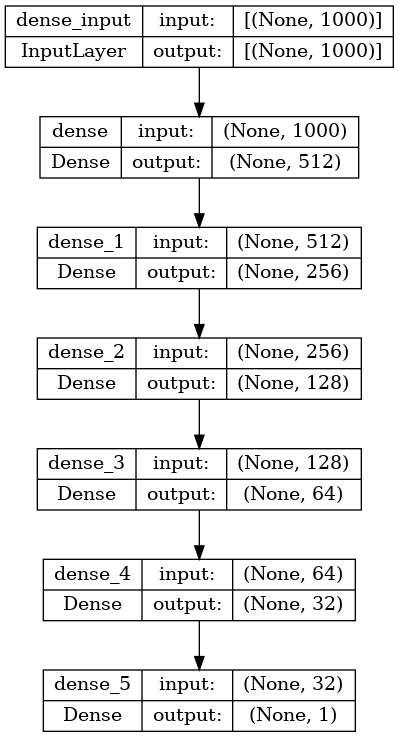

In [5]:
# Plot and save the model structure
model_structure_file = os.path.join(dir_output, 'model_structure.png')
plot_model(model, to_file=model_structure_file, show_shapes=True, show_layer_names=True)
print(f"Model structure saved to: {model_structure_file}")
display(Image(filename=model_structure_file))

## Plot the loss curve of the training process

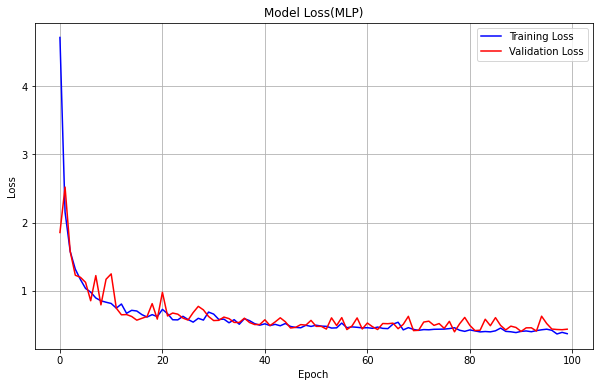

In [6]:
# Plot the loss curve during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss(MLP)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_loss.png'))
plt.show()

# Predict and calculate accuracy

## Model Prediction:
- `y_pred`: Contains the predicted values for the test set generated by the trained model.
- The predicted values are compared with the true values (`y_test`) to evaluate the model's performance.

## Performance Evaluation:
- **Mean Squared Error (MSE)**: This metric calculates the average squared difference between predicted and actual values. A lower value indicates a better fit.
- **R² Score**: This metric represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A value closer to 1 indicates a better model fit.

# Save Predictions:
- The predicted values (`y_pred`) are saved into a CSV file for future reference or further analysis.
- Example: `'predictions.csv'` (file where predictions are stored).

## Visualization:
- A plot is generated to compare the true and predicted values visually, providing insights into the model's performance.
- The plot is saved as `'true_vs_predicted.png'` for easy access.

16/16 [==============================] - 0s 4ms/step


Test MSE: 0.341422
Test R² Score: 0.959947


Test MSE: 0.341422
Test R² Score: 0.959947


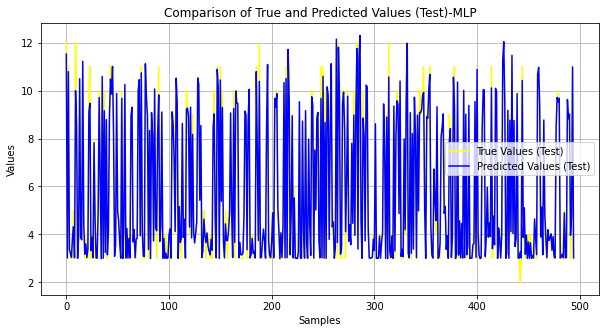

In [7]:
# Predict and calculate accuracy
y_pred = model.predict(X_test).flatten()

# Calculate and print Mean Squared Error (MSE) and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.6f}")
print(f"Test R² Score: {r2:.6f}")
logging.info(f"Test MSE: {mse:.6f}")
logging.info(f"Test R² Score: {r2:.6f}")

# Save predictions
predictions_file = os.path.join(dir_output, 'predictions.csv')
np.savetxt(predictions_file, y_pred, delimiter=',')

# Plot the comparison of predicted and true values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values (Test)', color='yellow', linewidth=1.5)
plt.plot(y_pred, label='Predicted Values (Test)', color='blue', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of True and Predicted Values (Test)-MLP')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'true_vs_predicted.png'))
plt.show()

